In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob
import os,sys
import itertools
from copy import deepcopy

In [8]:
name = "900steps_100fits"
work_path = "/data/user/tvaneede/GlobalFit/reco_processing/bdt/training/optimize_training/optimize_cuts/output/"

In [9]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/bdt/training/optimize_training")
from features_list_dict import features_list_dict
from flux_model_dict import flux_model_dict
from model_configs_dict import model_configs_dict

In [10]:
features_list_dict_copy = deepcopy(features_list_dict)
model_configs_dict_copy = deepcopy(model_configs_dict)

del model_configs_dict_copy["simpletopology"]
for key in features_list_dict: 
    if "rloglmilli_econf_evtgen" in key or "ibr" in key: del features_list_dict_copy[key]

df = pd.DataFrame(
    itertools.product(
        model_configs_dict_copy.keys(),
        flux_model_dict.keys(),
        features_list_dict_copy.keys(),
    ),
    columns=[
        "model_configs_name",
        "flux_model_name",
        "features_list_name",
    ],
)

In [11]:
df["name"] = (
    "mcd-" + df["model_configs_name"]
    + "_flux-" + df["flux_model_name"]
    + "_feat-" + df["features_list_name"]
)

df["model_path"] = df["name"].apply(lambda n: os.path.join(work_path, name, n))


In [12]:
def obtain_optimal_bdt_score( model_path ):
    model_name = model_path.split("/")[-1]
    df = pd.read_parquet(f"{model_path}/optimization.parquet")
    df["variance_ratio_sum"]  = df["variance_nue_ratio"] + df["variance_nutau_ratio"]
    optimal_row = df.loc[df["variance_ratio_sum"].idxmin()].copy()
    optimal_row["model_name"] = model_name
    return optimal_row

In [13]:
optimal_df = df.loc[df["model_path"].notna(), "model_path"].apply(obtain_optimal_bdt_score).apply(pd.Series)
df = df.join(optimal_df)

FileNotFoundError: [Errno 2] No such file or directory: '/data/user/tvaneede/GlobalFit/reco_processing/bdt/training/optimize_training/optimize_cuts/output/900steps_100fits/mcd-flavor_flux-hese_feat-11features_plus_rloglmilli_econf/optimization.parquet'

Lets first check for 1 set of features, what happens for a different flux or true mcd?

Conclusion: flux weighting doesnt matter. Could be studied. But the training on flavor or true topology makes a difference.

In [8]:
feature_mask = df["features_list_name"] == "13features"
flux_mask = df["flux_model_name"] == "hese"

print(df[ feature_mask & flux_mask ][["model_configs_name", "cut_bdt1", "cut_bdt2","variance_ratio_sum"]])

feature_mask = df["features_list_name"] == "13features"
model_mask = df["model_configs_name"] == "flavor"

print(df[ feature_mask & model_mask ][["flux_model_name", "cut_bdt1", "cut_bdt2","variance_ratio_sum"]])

feature_mask = df["features_list_name"] == "13features"
model_mask = df["model_configs_name"] == "truetopology"

print(df[ feature_mask & model_mask ][["flux_model_name", "cut_bdt1", "cut_bdt2","variance_ratio_sum"]])

  model_configs_name  cut_bdt1  cut_bdt2  variance_ratio_sum
0             flavor  0.333333  0.500000            0.838998
8       truetopology  0.033333  0.166667            0.939256
  flux_model_name  cut_bdt1  cut_bdt2  variance_ratio_sum
0            hese  0.333333       0.5            0.838998
  flux_model_name  cut_bdt1  cut_bdt2  variance_ratio_sum
8            hese  0.033333  0.166667            0.939256


Lets see what leads to better BDTs, using flavor or true topology


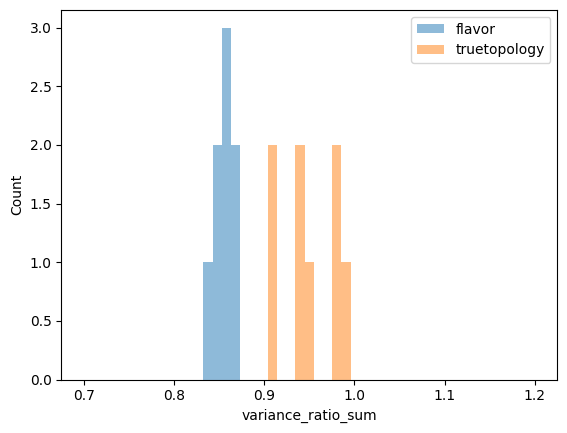

In [9]:
bins = np.linspace(0.7,1.2,50)
plt.hist(df.loc[df["model_configs_name"]=="flavor", "variance_ratio_sum"], bins=bins, alpha=0.5, label="flavor")
plt.hist(df.loc[df["model_configs_name"]=="truetopology", "variance_ratio_sum"], bins=bins, alpha=0.5, label="truetopology")
plt.xlabel("variance_ratio_sum"); plt.ylabel("Count"); plt.legend(); plt.show()

Training with flavor works best. Now lets look at the features

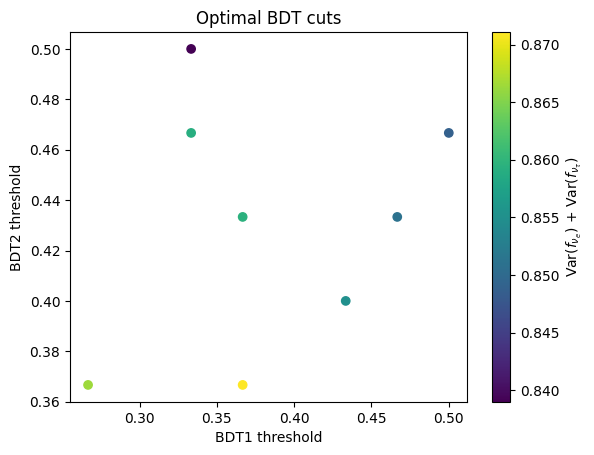

In [28]:
def scatter_optimal_bdt(df_subset):
    plt.figure()
    sc = plt.scatter(df_subset["cut_bdt1"], df_subset["cut_bdt2"], c=df_subset["variance_ratio_sum"])
    plt.xlabel("BDT1 threshold")
    plt.ylabel("BDT2 threshold")
    plt.title("Optimal BDT cuts")
    plt.colorbar(sc, label=r"Var($f_{\nu_e}$) + Var($f_{\nu_{\tau}}$)")
    plt.show()

flux_mask = df["flux_model_name"] == "hese"
model_mask = df["model_configs_name"] == "flavor"

scatter_optimal_bdt(df[flux_mask & model_mask])


In [11]:
df_sorted = df[flux_mask & model_mask].sort_values("variance_ratio_sum", ascending=True)
df_sorted[["features_list_name","cut_bdt1","cut_bdt2","variance_ratio_sum",'n_cascade', 'n_double','n_track']]

,features_list_name,cut_bdt1,cut_bdt2,variance_ratio_sum,n_cascade,n_double,n_track
0,13features,0.333333,0.500000,0.838998,235187.0,54300.0,80960.0
7,11features_plus_rloglmilli,0.500000,0.466667,0.848842,236969.0,56208.0,77270.0
4,11features_plus_econf,0.466667,0.433333,0.851067,236146.0,55689.0,78612.0
3,11features_plus_evtgen,0.433333,0.400000,0.854953,236388.0,59403.0,74656.0
5,11features_plus_millirlogl,0.333333,0.466667,0.859124,235408.0,57706.0,77333.0
1,11features,0.366667,0.433333,0.859487,235420.0,57937.0,77090.0
6,11features_plus_milliE,0.266667,0.366667,0.866391,233744.0,64417.0,72286.0
2,simple,0.366667,0.366667,0.871082,236138.0,66278.0,68031.0


In [12]:
df_sorted = df[flux_mask & model_mask].sort_values("variance_ratio_sum", ascending=True)
cols = [
    'features_list_name',
    'rate_tracks_NuE', 'rate_tracks_NuMu', 'rate_tracks_NuTau',
    'rate_tracks_conv', 
    'rate_cascades_NuE', 'rate_cascades_NuMu', 'rate_cascades_NuTau',
    'rate_cascades_conv',
    'rate_doubles_NuE', 'rate_doubles_NuMu', 'rate_doubles_NuTau',
    'rate_doubles_conv'
]

out = df_sorted[cols].rename(
    columns=lambda c: c
        .replace('rate_tracks_', '')
        .replace('rate_cascades_', '')
        .replace('rate_doubles_', '')
)

out = out.apply(
    lambda s: s.round(1) if s.dtype.kind in "fc" else s
)

out

,features_list_name,NuE,NuMu,NuTau,conv,NuE,NuMu,NuTau,conv,NuE,NuMu,NuTau,conv
0,13features,0.2,13.8,1.8,9.9,57.9,7.0,28.2,15.6,0.1,0.3,4.3,0.1
7,11features_plus_rloglmilli,0.1,13.5,1.7,9.6,58.0,7.3,28.4,15.9,0.1,0.3,4.2,0.1
4,11features_plus_econf,0.2,13.8,1.8,10.1,58.0,7.0,28.3,15.4,0.1,0.3,4.2,0.1
3,11features_plus_evtgen,0.2,13.4,1.7,9.5,58.0,7.3,28.4,16.0,0.1,0.4,4.3,0.1
5,11features_plus_millirlogl,0.2,13.7,1.9,9.8,57.9,7.0,28.2,15.8,0.1,0.3,4.3,0.2
1,11features,0.2,13.7,1.8,9.8,57.9,7.1,28.2,15.7,0.1,0.4,4.3,0.2
6,11features_plus_milliE,0.2,13.7,1.8,10.0,57.8,6.9,28.1,15.5,0.2,0.5,4.4,0.2
2,simple,0.1,13.4,1.7,9.9,58.0,7.0,28.4,15.6,0.2,0.7,4.3,0.2


I added some new training, including ibr and idc, and I did a new training with simple topology

In [15]:
name = "400steps_100fits_ibr_idc"
work_path = "/data/user/tvaneede/GlobalFit/reco_processing/bdt/training/optimize_training/optimize_cuts/output/"

In [16]:
features_list_dict_copy = deepcopy(features_list_dict)
model_configs_dict_copy = deepcopy(model_configs_dict)

del model_configs_dict_copy["truetopology"]
for key in features_list_dict: 
    if "rloglmilli_econf_evtgen" not in key and "ibr" not in key: del features_list_dict_copy[key]

df_extra = pd.DataFrame(
    itertools.product(
        model_configs_dict_copy.keys(),
        flux_model_dict.keys(),
        features_list_dict_copy.keys(),
    ),
    columns=[
        "model_configs_name",
        "flux_model_name",
        "features_list_name",
    ],
)

In [17]:
df_extra["name"] = (
    "mcd-" + df_extra["model_configs_name"]
    + "_flux-" + df_extra["flux_model_name"]
    + "_feat-" + df_extra["features_list_name"]
)

df_extra["model_path"] = df_extra["name"].apply(lambda n: os.path.join(work_path, name, n))

In [19]:
optimal_df_extra = df_extra.loc[df_extra["model_path"].notna(), "model_path"].apply(obtain_optimal_bdt_score).apply(pd.Series)
df_extra = df_extra.join(optimal_df_extra)

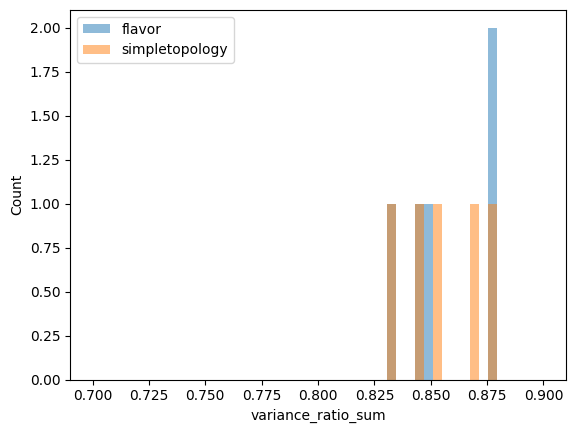

In [20]:
bins = np.linspace(0.7,0.9,50)
plt.hist(df_extra.loc[df_extra["model_configs_name"]=="flavor", "variance_ratio_sum"], bins=bins, alpha=0.5, label="flavor")
plt.hist(df_extra.loc[df_extra["model_configs_name"]=="simpletopology", "variance_ratio_sum"], bins=bins, alpha=0.5, label="simpletopology")
plt.xlabel("variance_ratio_sum"); plt.ylabel("Count"); plt.legend(); plt.show()

In [21]:
df_combined = pd.concat([df, df_extra], ignore_index=True)

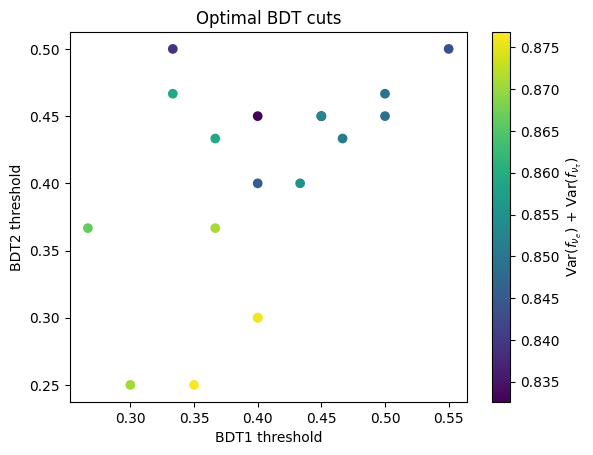

In [29]:
flux_mask = df_combined["flux_model_name"] == "hese"
model_mask = df_combined["model_configs_name"] != "truetopology"


scatter_optimal_bdt(df_combined[flux_mask & model_mask])

In [32]:
model_mask = df_combined["model_configs_name"] == "flavor"
model_mask = df_combined["model_configs_name"] != "truetopology"
df_sorted = df_combined[flux_mask & model_mask].sort_values("variance_ratio_sum", ascending=True)
out = df_sorted[["features_list_name","model_configs_name","cut_bdt1","cut_bdt2","variance_ratio_sum",'n_cascade', 'n_double','n_track']]

out = out.apply(
    lambda s: s.round(1) if s.dtype.kind in "fc" else s
)

out

,features_list_name,model_configs_name,cut_bdt1,cut_bdt2,variance_ratio_sum,n_cascade,n_double,n_track
23,11features_plus_rloglmilli_econf_evtgen,simpletopology,0.4,0.4,0.8,236280.0,55247.0,78920.0
18,11features_plus_rloglmilli_econf_evtgen,flavor,0.4,0.4,0.8,236221.0,55294.0,78932.0
0,13features,flavor,0.3,0.5,0.8,235187.0,54300.0,80960.0
24,11features_ibr_plus_rloglmilli_econf_evtgen,simpletopology,0.6,0.5,0.8,239023.0,52125.0,79299.0
19,11features_ibr_plus_rloglmilli_econf_evtgen,flavor,0.4,0.4,0.8,236575.0,58711.0,75161.0
7,11features_plus_rloglmilli,flavor,0.5,0.5,0.8,236969.0,56208.0,77270.0
20,11features_ibr_idc_plus_rloglmilli_econf_evtgen,flavor,0.5,0.4,0.8,237572.0,55199.0,77676.0
4,11features_plus_econf,flavor,0.5,0.4,0.9,236146.0,55689.0,78612.0
25,11features_ibr_idc_plus_rloglmilli_econf_evtgen,simpletopology,0.4,0.4,0.9,237814.0,55059.0,77574.0
3,11features_plus_evtgen,flavor,0.4,0.4,0.9,236388.0,59403.0,74656.0


In [39]:
model_mask = (df_combined["model_configs_name"] == "flavor")
feature_mask =  (df_combined["features_list_name"] != "13features")
df_sorted = df_combined[flux_mask & model_mask & feature_mask].sort_values("variance_ratio_sum", ascending=True)
cols = [
    'features_list_name',"variance_ratio_sum",
    'rate_tracks_NuE', 'rate_tracks_NuMu', 'rate_tracks_NuTau',
    'rate_tracks_conv', 
    'rate_cascades_NuE', 'rate_cascades_NuMu', 'rate_cascades_NuTau',
    'rate_cascades_conv',
    'rate_doubles_NuE', 'rate_doubles_NuMu', 'rate_doubles_NuTau',
    'rate_doubles_conv'
]

out = df_sorted[cols].rename(
    columns=lambda c: c
        .replace('rate_tracks_', '')
        .replace('rate_cascades_', '')
        .replace('rate_doubles_', '')
)

out = out.apply(
    lambda s: s.round(2) if s.dtype.kind in "fc" else s
)

out

,features_list_name,variance_ratio_sum,NuE,NuMu,NuTau,conv,NuE,NuMu,NuTau,conv,NuE,NuMu,NuTau,conv
18,11features_plus_rloglmilli_econf_evtgen,0.83,0.11,13.90,1.73,10.35,58.06,6.95,28.33,15.23,0.07,0.27,4.29,0.10
19,11features_ibr_plus_rloglmilli_econf_evtgen,0.85,0.07,13.40,1.66,9.61,58.07,7.36,28.38,15.93,0.10,0.35,4.31,0.15
7,11features_plus_rloglmilli,0.85,0.13,13.53,1.70,9.62,58.04,7.30,28.41,15.94,0.08,0.28,4.24,0.12
20,11features_ibr_idc_plus_rloglmilli_econf_evtgen,0.85,0.07,13.27,1.64,9.43,58.11,7.57,28.48,16.11,0.06,0.28,4.24,0.13
4,11features_plus_econf,0.85,0.17,13.78,1.76,10.10,57.98,7.01,28.34,15.44,0.09,0.32,4.25,0.14
3,11features_plus_evtgen,0.85,0.16,13.42,1.72,9.53,57.99,7.29,28.36,16.01,0.09,0.40,4.27,0.14
5,11features_plus_millirlogl,0.86,0.21,13.73,1.85,9.77,57.91,7.05,28.21,15.75,0.12,0.34,4.29,0.16
1,11features,0.86,0.21,13.68,1.79,9.85,57.91,7.06,28.24,15.68,0.12,0.37,4.31,0.15
6,11features_plus_milliE,0.87,0.23,13.71,1.83,9.97,57.84,6.87,28.11,15.51,0.17,0.53,4.41,0.20
2,simple,0.87,0.12,13.42,1.68,9.90,57.97,7.04,28.35,15.56,0.15,0.65,4.32,0.22


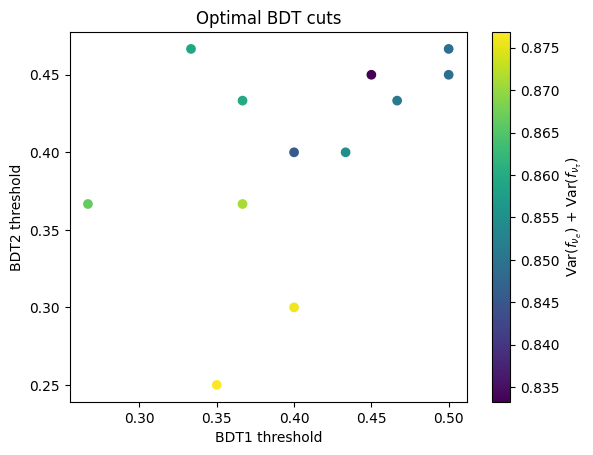

In [41]:
scatter_optimal_bdt(df_combined[flux_mask & model_mask & feature_mask])